<a href="https://colab.research.google.com/github/UsaMasa/Python/blob/master/CNN_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine　Learning for High Energy Physics 2019復習ノートブック
本ノートブックは2019/07/01 - 2019/07/10までに行われたMLHEP2019 Phase 1 Competitionの復習ノートブックです。
必要なデータやスタートアップキット、ベースラインマクロ等は以下からダウンロードできます。

コンペティションサイト：　https://codalab.coresearch.club/competitions/70#learn_the_details-overview

必要な知識を得るための教材等は以下の運営サイトでも公開されています。

MLHEP 2019 : https://indico.cern.ch/event/768915/


## Phase 1 コンペの題目
LHCbに使われているカロリメータ検出器（電磁カロリメータ＋ハドロンカロリメータ）の情報（Energy deposit）から、機械学習の手法を用いて初期位置と初期運動量を再構成することを目標とする。

## 実装
PyTorchを用いてCNNを構成する。

### 初期設定からデータの読み込みまで

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from IPython.display import clear_output
sns.set()

In [0]:
device = torch.device('cuda:0') #GPU set
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
train_data_path = '/gdrive/My Drive/mlhep2019/data_train.npz'
val_data_path = '/gdrive/My Drive/mlhep2019/data_val.npz'
test_data_path = '/gdrive/My Drive/mlhep2019/data_test.npz'

使いたい情報としては、エネルギーデポジット（30x30の画像）、運動量（3次元）、位置（2次元）、粒子の種類（1）がある。

In [0]:
# 訓練用のデータセットを開く
data_real = np.load(train_data_path, allow_pickle=True)
print(list(data_real.keys()))

['EnergyDeposit', 'ParticlePoint', 'ParticleMomentum', 'ParticlePDG']


In [0]:
# [data_size, 900]
EnergyDeposit = data_real['EnergyDeposit']

In [0]:
# [data_size, channels, img_size_x, img_size_y]の形にreshapeする
# -1を入れたところは自動で判断してくれる。1つの30x30の配列に変換された。
print(EnergyDeposit.shape)
EnergyDeposit = EnergyDeposit.reshape(-1, 1, 30, 30)
EnergyDeposit = EnergyDeposit[0:30000, : , : , : ]
print(EnergyDeposit.shape)

(50250, 30, 30)
(30000, 1, 30, 30)


In [0]:
# [data_size, 3]
ParticleMomentum = data_real['ParticleMomentum']
ParticleMomentum = ParticleMomentum[0:30000, :]
# [data_size, 2]
ParticlePoint = data_real['ParticlePoint']
ParticlePoint = ParticlePoint[0:30000, :]
# [data_size, 1]
ParticlePDG = data_real['ParticlePDG']
print(ParticlePDG.shape)
ParticlePDG = ParticlePDG[0:30000]
print(ParticlePDG.shape)

(50250,)
(30000,)


使用する特徴量の抽出

In [0]:
#今回はz方向には考えない。：2で0,1要素のみを入れる。
ParticleMomentum = ParticleMomentum[:, :2]
ParticlePoint = ParticlePoint[:, :2]
#numpyからpytorchのtensorへと変換する。
EnergyDeposit = torch.tensor(EnergyDeposit).float()
ParticleMomentum = torch.tensor(ParticleMomentum).float()
ParticlePoint = torch.tensor(ParticlePoint).float()
#上三つを、TensorDatasetというフォーマットへ変換し、pytorch dataloderへ突っ込む。
BATCH_SIZE = 1024
calo_dataset = utils.TensorDataset(EnergyDeposit, ParticleMomentum, ParticlePoint)
calo_dataloader = torch.utils.data.DataLoader(calo_dataset, 
                                              batch_size=BATCH_SIZE, 
                                              pin_memory=True, shuffle=True)

## モデルの構築

・Optimizer : Adam

・Learning rate : 0.0001

・畳み込み層 ：　4層

・FC層　：　4層

・Dropout : 0.3

・活性化関数 ： LeLU

In [0]:
class Regressor(nn.Module):#nn.moduleはベークラス。モデルを作る際には継承する。
    def __init__(self):
        super(Regressor, self).__init__()
        #conv2d(input_channel, output_channel, ker_size, stride)
        #要は、output枚のサイズ2のフィルタにストライド2で通している。
        self.conv1 = nn.Conv2d(1, 16, 2, stride=2, padding = 0)
        self.bn1 = nn.BatchNorm2d(16)
        #self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(16, 32, 2, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        #self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(32, 64, 2)
        self.bn3 = nn.BatchNorm2d(64)
        #self.pool3 = nn.MaxPool2d(2)
        
        self.conv4 = nn.Conv2d(64, 128, 2)
        
        self.dropout = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(3200, 512) #インプットー＞隠れ層
        self.fc2 = nn.Linear(512, 256)
        self.fc25 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 2 + 2) #隠れ層ー＞アウトプット
        
       
        
    def forward(self, x):
        x = self.dropout(F.relu(self.bn1(self.conv1(x))))# Fはtorch.nn.functional
        x = self.dropout(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(F.relu(self.bn3(self.conv3(x))))
        x = F.relu(self.conv4(x)) # 64, 5, 5
        x = x.view(len(x), -1) #len(x) x (残り)の形に変換。すなわち、xの列。
        '''
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        x = x.view(len(x), -1) 
        '''
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc25(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x) #これが得られた目標変数（確率的なもの）。

In [0]:
regressor = Regressor().to(device)

In [0]:
learning_rate = 0.0001
opt = optim.Adam(regressor.parameters(), lr=learning_rate)

ParticleMomentum_mean, ParticlePoint_mean = ParticleMomentum.mean(dim=0), ParticlePoint.mean(dim=0)
ParticleMomentum_ParticlePoint_mean = torch.cat([ParticleMomentum_mean, ParticlePoint_mean]).to(device)

def metric_relative_mse(y_true, y_pred):
    return ((y_true - y_pred).pow(2).mean(dim=0) / (y_true - ParticleMomentum_ParticlePoint_mean).pow(2).mean(dim=0)).sum()

## 損失関数の計算

In [0]:
# L1正則化はスパースな解を得やすいため、不要なパラメータを削りたいときに適する
# 一方で、L2正則化は過学習を抑え、汎化された滑らかなモデルを得やすい
#loss_fn = torch.nn.L1Loss().to(device)
loss_fn = torch.nn.MSELoss().to(device)

In [0]:
class RunningAverageMeter(object):
    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()
    def reset(self):
        self.val = None
        self.avg = 0
    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [0]:
def run_training(epochs=10):
    losses = []
    metrics = []
    # 移動平均の初期化
    loss_meter = RunningAverageMeter(momentum=0.99)
    metric_meter = RunningAverageMeter(momentum=0.99)

    for epoch in tqdm(range(epochs)):
        
        for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b in calo_dataloader:
            # device(cuda-device)へ特徴量を移す
            EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
                                                                   ParticleMomentum_b.to(device), \
                                                                   ParticlePoint_b.to(device)
            #print(EnergyDeposit_b)
            
            # predictの結果 [batch_size, 4]
            pred = regressor(EnergyDeposit_b)

            # 損失関数の計算
            loss = loss_fn(pred, torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1))
            opt.zero_grad()#前回のステップから勾配を初期化
            loss.backward()#損失関数から新しい勾配を計算する
            opt.step()#weight parameterを更新する
            
            # metricsの値を詰める（視覚化用）
            loss_meter.update(loss.item())
            metric_meter.update(metric_relative_mse(pred, torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1)).item())
            losses.append(loss_meter.avg)
            metrics.append(metric_meter.avg)

            # lossとmetricsをプロットする
        if epoch%10 == 0:
            clear_output(wait=True)       
            plt.figure(figsize=(12, 12))
            plt.plot(losses, label='Loss')
            plt.legend()
            plt.show()

            plt.figure(figsize=(12, 12))
            plt.plot(metrics, label='Metric')
            plt.legend()  
            plt.show()
            print(metrics[-1])

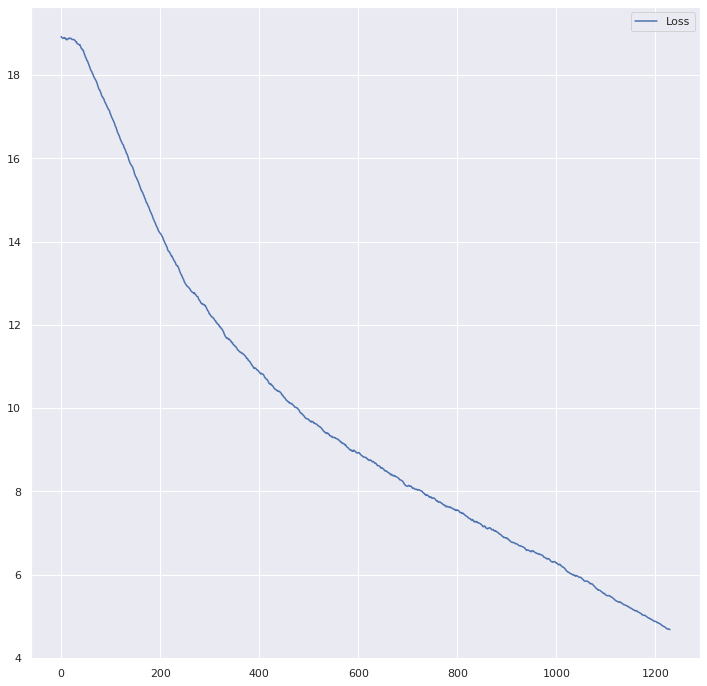

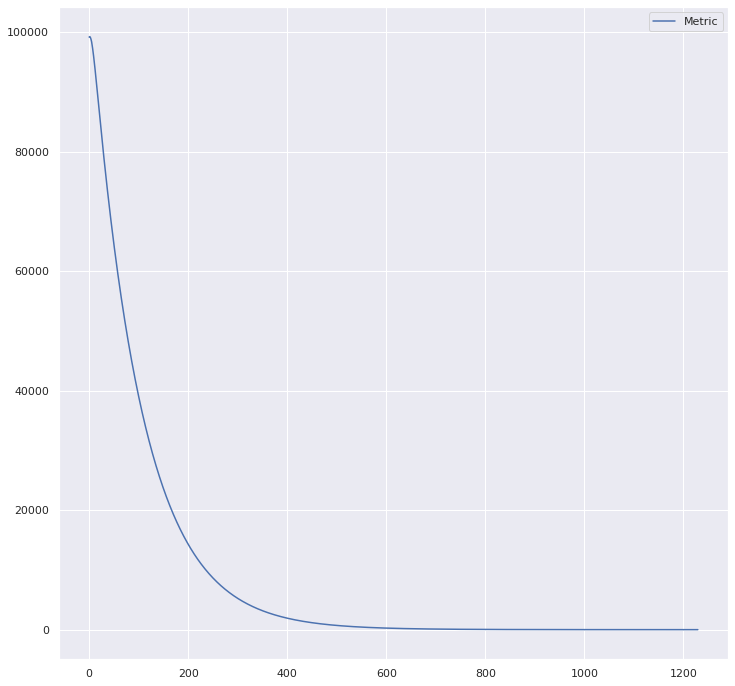

 82%|████████▏ | 41/50 [00:42<00:10,  1.16s/it]

1.833881043164007


100%|██████████| 50/50 [00:51<00:00,  1.02it/s]


In [0]:
run_training(50)

## 評価セットに対する予測


In [0]:
data_val = np.load(val_data_path, allow_pickle=True)
EnergyDeposit_val = data_val['EnergyDeposit']
EnergyDeposit_val = EnergyDeposit_val.reshape(-1, 1, 30, 30)

In [0]:
print(list(data_val.keys()))

['EnergyDeposit']


In [0]:
#px, py, x, yからなる、[data_num, 4]の配列を予測する
prediction_val = regressor.cpu()(torch.tensor(EnergyDeposit_val).float())
# 粒子の初期運動量と、初期位置に配列を二分する
ParticleMomentum_val, ParticlePoint_val = prediction_val.detach().numpy()[:, :2], prediction_val.detach().numpy()[:, 2:]

In [0]:
print(ParticleMomentum_val.shape)

(50250, 2)


In [0]:
# predictionファイルを .npz formatで保存する
np.savez_compressed('data_val_prediction.npz', 
                    ParticlePoint=ParticlePoint_val, 
                    ParticleMomentum=ParticleMomentum_val)

In [0]:
del prediction_val
import gc
gc.collect()

In [0]:
data_val = None
EnergyDeposit_val = None
gc.collect()

## 性能評価

訓練データを分けてモデルの評価を行う。



In [0]:
data_sol = np.load(train_data_path, allow_pickle=True)
EnergyDeposit_sol = data_sol['EnergyDeposit']
EnergyDeposit_sol = EnergyDeposit_sol.reshape(-1, 1, 30, 30)
print(EnergyDeposit_sol.shape)
EnergyDeposit_sol = EnergyDeposit_sol[30000: , : , : , :]
print(EnergyDeposit_sol.shape)

(50250, 1, 30, 30)
(20250, 1, 30, 30)


In [0]:
#px, py, x, yからなる、[data_num, 4]の配列を予測する
prediction_sol = regressor.cpu()(torch.tensor(EnergyDeposit_sol).float())
# 粒子の初期運動量と、初期位置に配列を二分する
ParticleMomentum_sol, ParticlePoint_sol = prediction_sol.detach().numpy()[:, :2], prediction_sol.detach().numpy()[:, 2:]

In [0]:
np.savez_compressed('data_sol_prediction.npz', 
                    ParticlePoint=ParticlePoint_sol, 
                    ParticleMomentum=ParticleMomentum_sol)

In [0]:
ParticleMomentum_true = data_sol['ParticleMomentum']# [data_size, 3]
ParticleMomentum_true = ParticleMomentum_true[30000:, :2]
ParticlePoint_true = data_sol['ParticlePoint']# [data_size, 2]
ParticlePoint_true = ParticlePoint_true[30000:, :2]
print(ParticlePoint_true.shape)

(20250, 2)


In [0]:
np.savez_compressed('data_sol_true.npz', 
                    ParticlePoint=ParticlePoint_true, 
                    ParticleMomentum=ParticleMomentum_true)

In [0]:
import numpy as np

ParticleMomentum_MEAN = np.array([0., 0.])
ParticlePoint_MEAN = np.array([0., 0.])

def scoring_function(solution_file, predict_file):
    score = 0.
    
    solution = np.load(solution_file, allow_pickle=True)
    predict = np.load(predict_file, allow_pickle=True)
    ParticleMomentum_sol = solution['ParticleMomentum'][:, :2]
    ParticlePoint_sol = solution['ParticlePoint'][:, :2]
    
    ParticleMomentum_pred = predict['ParticleMomentum'][:, :2]
    ParticlePoint_pred = predict['ParticlePoint'][:, :2]
    
    score += np.sum(np.square(ParticleMomentum_sol - ParticleMomentum_pred).mean(axis=0) / np.square(ParticleMomentum_sol - ParticleMomentum_MEAN).mean(axis=0))
    score += np.sum(np.square(ParticlePoint_sol - ParticlePoint_pred).mean(axis=0) / np.square(ParticlePoint_sol - ParticlePoint_MEAN).mean(axis=0))
    return np.sqrt(score)

In [0]:
solution_file = '/content/data_sol_true.npz'
predict_file = '/content/data_sol_prediction.npz'
print(scoring_function(solution_file, predict_file))

0.8512018294635643
